In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pyproj
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import pyproj
import math
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import pyproj
import math
import shapely as sh
import pandas as pd
import rioxarray
import xarray as xr
import cartopy.crs as ccrs

c:\Users\Charlie\Documents\GitHub\mapping-challenge\.venv\Lib\site-packages\geopandas\_compat.py:153: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  set_use_pygeos()
C:\Users\Charlie\AppData\Local\Temp\ipykernel_376\1206727060.py:4: DeprecationWarning: GeoPandas is set to use PyGEOS over Shapely. PyGEOS support is deprecatedand will be removed in GeoPandas 1.0, released in the Q1 of 2024. Please migrate to Shapely 2.0 (https://geopandas.org/en/stable/docs/user_guide/pygeos_to_shapely.html).
  import geopandas as gpd


In [3]:
# https://observablehq.com/@toja/spilhaus-world-ocean-map-in-a-square

# https://storymaps.arcgis.com/stories/756bcae18d304a1eac140f19f4d5cb3d

# https://observablehq.com/d/bb73e74c1685e498

# https://storymaps.arcgis.com/stories/756bcae18d304a1eac140f19f4d5cb3d

    # Geographic Coordinate System: GCS WGS 1984
    # Projection: Adams Square II
    # False Easting: 0 m
    # False Northing: 0 m
    # Scale Factor: 1
    # Azimuth: 40.17823482°
    # Longitude of Center: 66.94970198°E
    # Latitude of Center: 49.56371678°S
    # XY Plane Rotation: 45°

In [4]:
def transform(lon,lat,lon_off,lat_off):
    lon = (lon+lon_off+180)%360-180
    lat = (lat+lat_off+90)%180-90
    return lon,lat

# x-y rotation
def rotator(x,y,theta):
    theta = theta*math.pi/180
    x_d = x*math.cos(theta)-y*math.sin(theta)
    y_d = x*math.sin(theta)+y*math.cos(theta)
    return x_d,y_d

In [5]:
rds = rioxarray.open_rasterio("NE2_LR_LC_SR_W.tif",decode_coords="all")

In [6]:
rds

<xarray.DataArray (band: 3, y: 8100, x: 16200)>
[393660000 values with dtype=uint8]
Coordinates:
  * band         (band) int32 1 2 3
  * x            (x) float64 -180.0 -180.0 -179.9 -179.9 ... 179.9 180.0 180.0
  * y            (y) float64 89.99 89.97 89.94 89.92 ... -89.94 -89.97 -89.99
    spatial_ref  int32 0
Attributes:
    AREA_OR_POINT:           Area
    TIFFTAG_DATETIME:        2012:07:16 09:57:53
    TIFFTAG_RESOLUTIONUNIT:  2 (pixels/inch)
    TIFFTAG_SOFTWARE:        Adobe Photoshop CS5 Macintosh
    TIFFTAG_XRESOLUTION:     72
    TIFFTAG_YRESOLUTION:     72
    scale_factor:            1.0
    add_offset:              0.0

In [7]:
rds = rds.coarsen(x=10).mean().coarsen(y=10).mean().astype(int)

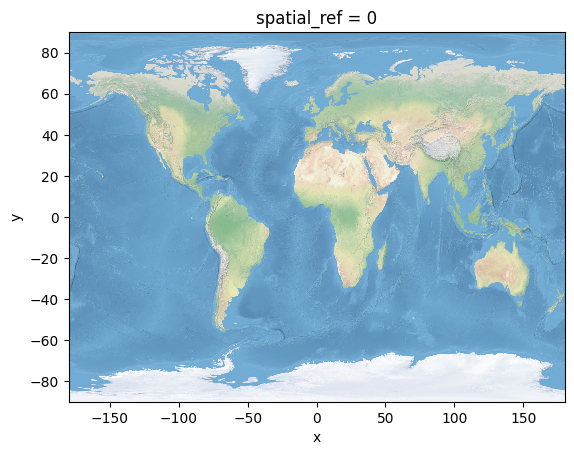

In [8]:
rds.squeeze().plot.imshow()

In [9]:
# rds["band"==1].plot.imshow()

In [10]:
transform_proj = pyproj.Proj(proj="ob_tran", o_proj="adams_ws2", o_lat_p=-66.95+90, o_lon_p=49.56+180, lon_0=40.18-90) 
transform_proj = pyproj.Proj(proj="ob_tran", o_proj="adams_ws2", o_lat_p=-65+90, o_lon_p=30+180, lon_0=27-90) 
transform_proj = pyproj.Proj(proj="ob_tran", o_proj="adams_ws2", o_lat_p=-65+90, o_lon_p=23+180, lon_0=27-90) 

In [11]:
# Create a meshgrid
xv, yv = np.meshgrid(rds["x"], rds['y'])

x2, y2 = transform_proj(xv, yv)

x2, y2 = rotator(x2, y2,45)

rds.coords['x2'] = (('y', 'x'), x2)
rds.coords['y2'] = (('y', 'x'), y2)

In [12]:
# rds.mean(dim="band").plot(x="x2",y="y2")

In [13]:
# https://stackoverflow.com/questions/14120222/matplotlib-imshow-with-irregular-spaced-data-points/14140554#14140554

import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

xs0 = rds.coords['x2'].values.flatten()
ys0 = rds.coords['y2'].values.flatten()
rs0 = rds.sel(band=1).values.flatten()
gs0 = rds.sel(band=2).values.flatten()
bs0 = rds.sel(band=3).values.flatten()

xs,ys = np.mgrid[xs0.min():xs0.max():(xs0.max()-xs0.min())/1000, 
                 ys0.min():ys0.max():(ys0.max()-ys0.min())/1000]

r_resampled = griddata((xs0, ys0), rs0, (xs, ys),method="nearest").astype(int)
g_resampled = griddata((xs0, ys0), gs0, (xs, ys),method="nearest").astype(int)
b_resampled = griddata((xs0, ys0), bs0, (xs, ys),method="nearest").astype(int)



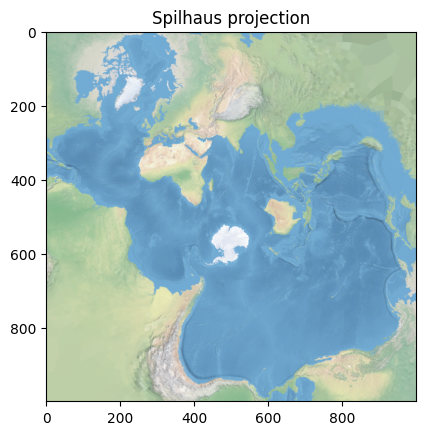

In [14]:
image_rgb = np.dstack([r_resampled,g_resampled,b_resampled])

plt.imshow(image_rgb)
plt.title("Spilhaus projection")
plt.show()

In [15]:
# https://www.movebank.org/cms/movebank-main

In [16]:
VotGH = pd.read_csv("Voyage of the Golden Hinde2.csv")

In [32]:
X2, Y2 = transform_proj(VotGH["X"], VotGH["Y"])
VotGH["X2"], VotGH["Y2"] = rotator(X2, Y2,-45)

In [33]:
VotGH

,X,Y,Name,description,timestamp,begin,end,altitudeMode,tessellate,extrude,visibility,drawOrder,icon,X2,Y2
0,-4.142528,50.375682,1. Plymouth 25-11-1577,NaN,NaN,NaN,NaN,NaN,-1,0,-1,NaN,NaN,-5.401095e+06,5.576043e+06
1,-11.881812,42.779897,1.1 Waypoint,NaN,NaN,NaN,NaN,NaN,-1,0,-1,NaN,NaN,-5.781105e+06,4.933860e+06
2,-9.786692,31.497218,"2. Mogador Island, 25-12-1577",NaN,NaN,NaN,NaN,NaN,-1,0,-1,NaN,NaN,-5.557765e+06,4.074361e+06
3,-14.258808,27.262333,2.1 Waypoint,NaN,NaN,NaN,NaN,NaN,-1,0,-1,NaN,NaN,-5.804099e+06,3.709798e+06
4,-16.699990,22.285287,"3. Cape Barbas, 1578-01-15",NaN,NaN,NaN,NaN,NaN,-1,0,-1,NaN,NaN,-5.912018e+06,3.301841e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,18.474724,-34.357755,"46. Cape of Good Hope, South Africa 1580-06-15",NaN,NaN,NaN,NaN,NaN,-1,0,-1,NaN,NaN,-2.323692e+06,6.381969e+05
70,-9.629063,5.244120,"47. Cestos River, Liberia 1580-07-15",NaN,NaN,NaN,NaN,NaN,-1,0,-1,NaN,NaN,-5.084756e+06,2.187639e+06
71,-13.256237,8.492987,"48. White Man's Bay, Freetown, Sierra Leone 15...",NaN,NaN,NaN,NaN,NaN,-1,0,-1,NaN,NaN,-5.417003e+06,2.332590e+06
72,-32.405271,14.564554,48.1 Waypoint,NaN,NaN,NaN,NaN,NaN,-1,0,-1,NaN,NaN,-7.040391e+06,2.475761e+06


Text(0.5, 1.0, "The Golden Hinde's Circumnavigation of the World")

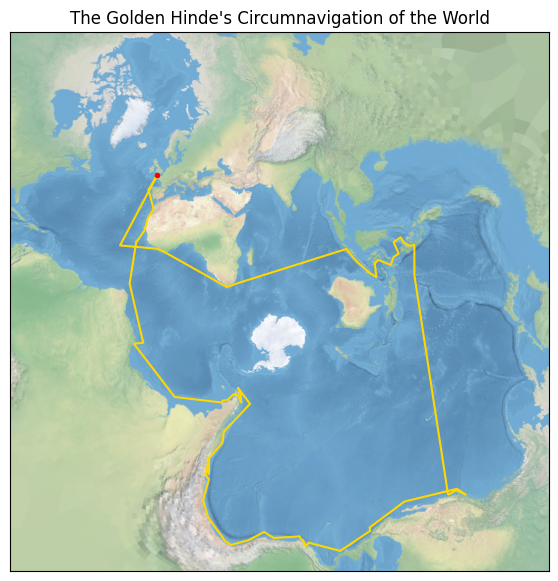

In [71]:
from matplotlib import pyplot as plt

VotGH.plot(x="X2",y="Y2",color="gold",legend=None,figsize=(7,7))

plt.plot(VotGH.iloc[0]["X2"],VotGH.iloc[0]["Y2"],"r.")

scale = 11900000

plt.imshow(image_rgb,extent=(-scale,scale,-scale,scale))

plt.gca().axes.get_yaxis().set_visible(False)
plt.gca().axes.get_xaxis().set_visible(False)

plt.title("The Golden Hinde's Circumnavigation of the World")
